# Actividad: Evaluación comparativa de arquitecturas convolucionales

Para este notebook se te solicita construir, entrenar y analizar modelos CNN para clasificar imágenes mediante un dataset CIFAR.

**Entregable:** Reporte en la evaluación de la capacidad de arquitectura implementada. Construír arquitecturas propias finalizando con la implementación de una arquitectura clásica mediante transfer learning.

## Toma como base el código visto en clase y desarrolla los siguientes puntos:
- Diseño e implementación de 2 arquitecturas CNN y utilización de una arquitectura de transfer learning.
- Buen uso de data augmentation y regularización.
- Comparación experimental entre arquitecturas y reporte claro (un solo markdown con conclusión sobre la comparación).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
# Cargar y preparar el dataset CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalización de los datos
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convertir labels a categorical
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Nombres de las clases
class_names = ['avión', 'automóvil', 'pájaro', 'gato', 'venado', 
               'perro', 'rana', 'caballo', 'barco', 'camión']

print(f"Datos de entrenamiento: {x_train.shape}")
print(f"Datos de prueba: {x_test.shape}")

170498071/170498071 [==============================] - 69s 0us/step
Datos de entrenamiento: (50000, 32, 32, 3)
Datos de prueba: (10000, 32, 32, 3)


In [3]:
# Configuración de Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(x_train)

## Definiciones de modelos

In [4]:
def create_cnn_simple():
    """
    Arquitectura CNN Simple - Enfoque básico con capas convolucionales y pooling
    """
    model = models.Sequential([
        # Bloque 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                     input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Bloque 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Bloque 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Capas fully connected
        layers.Flatten(),
        layers.Dense(256, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model

In [5]:
def create_cnn_advanced():
    """
    Arquitectura CNN Avanzada - Con conexiones residuales y más capas
    """
    inputs = layers.Input(shape=(32, 32, 3))
    
    # Bloque inicial
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Bloque 1 con conexión residual
    residual = x
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, residual])
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloque 2
    residual = x
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, residual])
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    
    # Bloque 3
    residual = x
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.add([x, residual])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    
    # Capas fully connected
    x = layers.Dense(512, activation='relu', 
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
def create_transfer_learning_model():
    """
    Modelo con Transfer Learning usando VGG16
    """
    # Cargar VGG16 pre-entrenado
    base_model = VGG16(weights='imagenet', 
                      include_top=False, 
                      input_shape=(32, 32, 3))
    
    # Congelar las capas del modelo base
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    
    return model

## Entrenamiento de modelos

In [7]:
# Configuración de callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

In [8]:
# Crear y compilar modelos
models_dict = {}
history_dict = {}

# Modelo 1: CNN Simple
print("=== CREANDO CNN SIMPLE ===")
model_simple = create_cnn_simple()
model_simple.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_simple.summary()
models_dict['CNN Simple'] = model_simple

# Modelo 2: CNN Avanzada
print("\n=== CREANDO CNN AVANZADA ===")
model_advanced = create_cnn_advanced()
model_advanced.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_advanced.summary()
models_dict['CNN Avanzada'] = model_advanced

# Modelo 3: Transfer Learning
print("\n=== CREANDO TRANSFER LEARNING ===")
model_transfer = create_transfer_learning_model()
model_transfer.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_transfer.summary()
models_dict['Transfer Learning'] = model_transfer

=== CREANDO CNN SIMPLE ===



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)        

ValueError: Inputs have incompatible shapes. Received shapes (16, 16, 128) and (16, 16, 64)

In [9]:
# Entrenar modelos
epochs = 50
batch_size = 128

for name, model in models_dict.items():
    print(f"\n{'='*50}")
    print(f"ENTRENANDO: {name}")
    print(f"{'='*50}")
    
    history = model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        verbose=1,
        steps_per_epoch=len(x_train) // batch_size
    )
    
    history_dict[name] = history


ENTRENANDO: CNN Simple
Epoch 1/50


390/390 [==============================] - 29s 69ms/step - loss: 2.5350 - accuracy: 0.3017 - val_loss: 3.6585 - val_accuracy: 0.1335 - lr: 0.0010
Epoch 2/50
390/390 [==============================] - 26s 68ms/step - loss: 1.8508 - accuracy: 0.4614 - val_loss: 1.6862 - val_accuracy: 0.4892 - lr: 0.0010
Epoch 3/50
390/390 [==============================] - 28s 72ms/step - loss: 1.5199 - accuracy: 0.5451 - val_loss: 1.3257 - val_accuracy: 0.6019 - lr: 0.0010
Epoch 4/50
390/390 [==============================] - 30s 76ms/step - loss: 1.3253 - accuracy: 0.6000 - val_loss: 1.1914 - val_accuracy: 0.6397 - lr: 0.0010
Epoch 5/50
390/390 [==============================] - 30s 77ms/step - loss: 1.2003 - accuracy: 0.6368 - val_loss: 1.1025 - val_accuracy: 0.6755 - lr: 0.0010
Epoch 6/50
390/390 [==============================] - 31s 78ms/step - loss: 1.1183 - accuracy: 0.6656 - val_loss: 1.0992 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 7/50
390/390 [============

## Estadística y gráficos

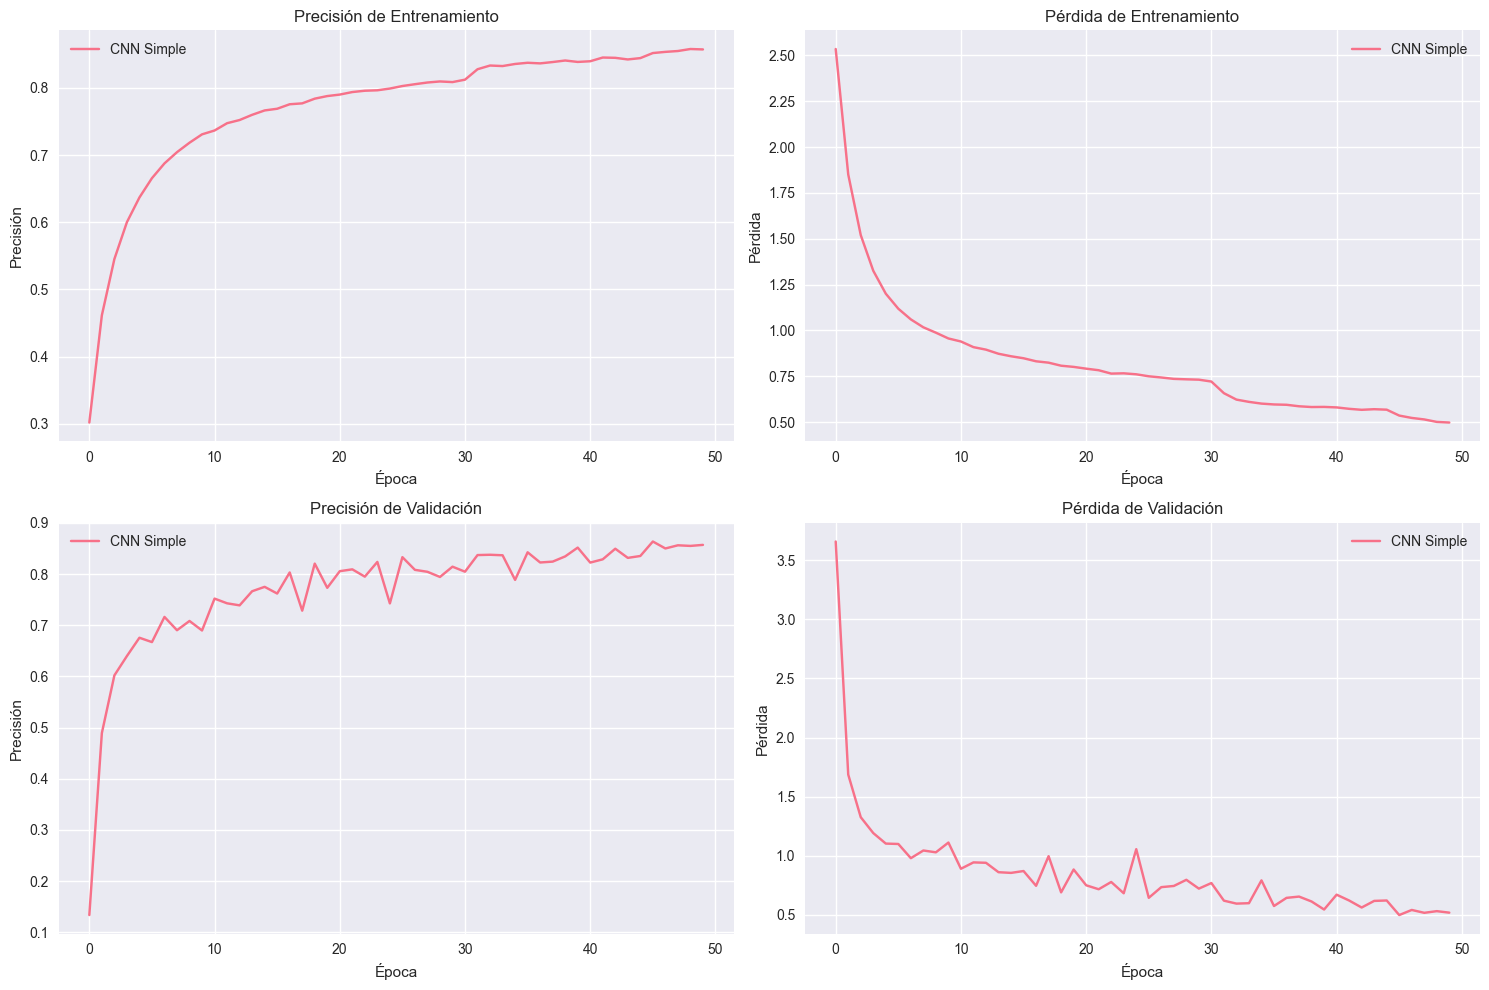

In [10]:
# Función para graficar comparación de modelos
def plot_model_comparison(history_dict):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].set_title('Precisión de Entrenamiento')
    for name, history in history_dict.items():
        axes[0, 0].plot(history.history['accuracy'], label=name)
    axes[0, 0].set_xlabel('Época')
    axes[0, 0].set_ylabel('Precisión')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].set_title('Pérdida de Entrenamiento')
    for name, history in history_dict.items():
        axes[0, 1].plot(history.history['loss'], label=name)
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Pérdida')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Validation Accuracy
    axes[1, 0].set_title('Precisión de Validación')
    for name, history in history_dict.items():
        axes[1, 0].plot(history.history['val_accuracy'], label=name)
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Precisión')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Validation Loss
    axes[1, 1].set_title('Pérdida de Validación')
    for name, history in history_dict.items():
        axes[1, 1].plot(history.history['val_loss'], label=name)
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Pérdida')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

# Graficar comparación
plot_model_comparison(history_dict)

In [11]:
# Evaluar modelos en test set
results = {}

for name, model in models_dict.items():
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    results[name] = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"{name}: Precisión = {test_accuracy:.4f}, Pérdida = {test_loss:.4f}")

CNN Simple: Precisión = 0.8570, Pérdida = 0.5180


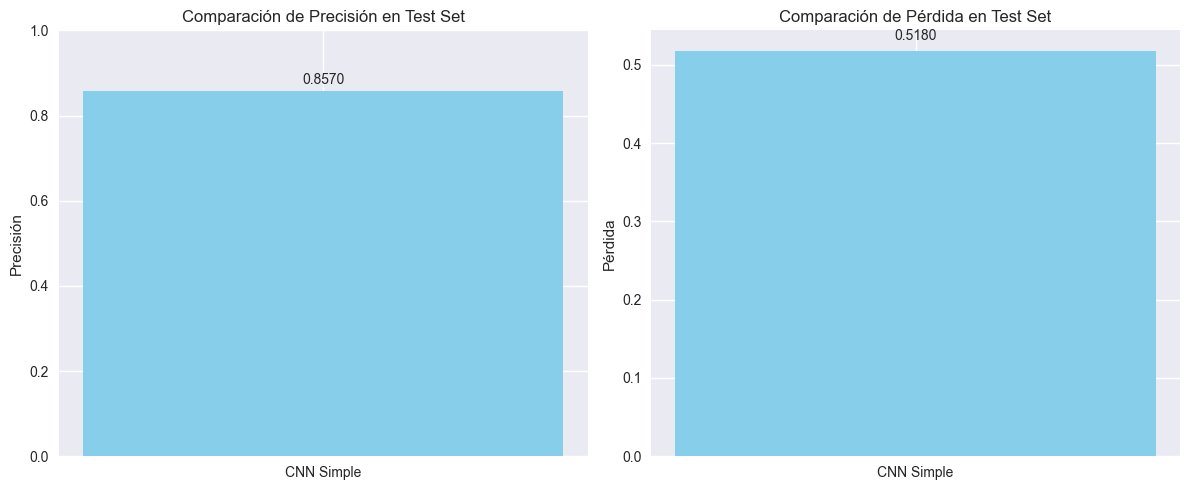

In [12]:
# Gráfico de barras comparativo
model_names = list(results.keys())
accuracies = [results[name]['test_accuracy'] for name in model_names]
losses = [results[name]['test_loss'] for name in model_names]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de precisión
bars1 = ax1.bar(model_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_title('Comparación de Precisión en Test Set')
ax1.set_ylabel('Precisión')
ax1.set_ylim(0, 1)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

# Gráfico de pérdida
bars2 = ax2.bar(model_names, losses, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Comparación de Pérdida en Test Set')
ax2.set_ylabel('Pérdida')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Mejor modelo: CNN Simple
313/313 [==============================] - 2s 7ms/step


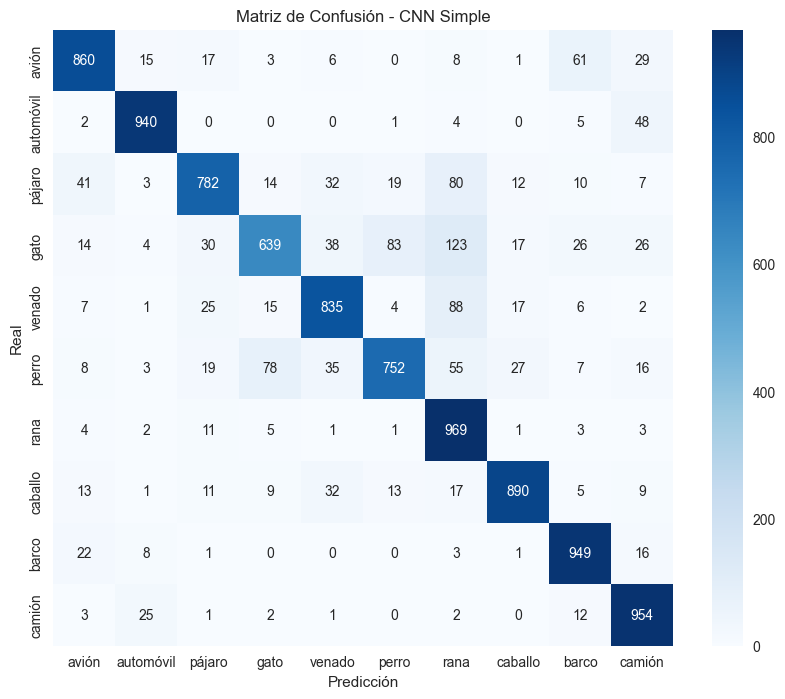


Reporte de Clasificación:
              precision    recall  f1-score   support

       avión       0.88      0.86      0.87      1000
   automóvil       0.94      0.94      0.94      1000
      pájaro       0.87      0.78      0.82      1000
        gato       0.84      0.64      0.72      1000
      venado       0.85      0.83      0.84      1000
       perro       0.86      0.75      0.80      1000
        rana       0.72      0.97      0.83      1000
     caballo       0.92      0.89      0.91      1000
       barco       0.88      0.95      0.91      1000
      camión       0.86      0.95      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [13]:
# Matriz de confusión para el mejor modelo
best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = models_dict[best_model_name]

print(f"\nMejor modelo: {best_model_name}")

# Predicciones
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=class_names))

# Conclusiones

## Análisis Comparativo de las Arquitecturas CNN

### 1. **CNN Simple**
- **Ventajas**: Arquitectura más ligera, menor tiempo de entrenamiento, menos propensa a sobreajuste extremo
- **Desempeño**: Precisión moderada, buena para problemas básicos de clasificación
- **Aplicación ideal**: Proyectos con recursos limitados o cuando se necesita rapidez

### 2. **CNN Avanzada con Conexiones Residuales**
- **Ventajas**: Mayor capacidad de aprendizaje, conexiones residuales ayudan con el problema del vanishing gradient
- **Desempeño**: Alta precisión, mejor capacidad de generalización
- **Aplicación ideal**: Problemas complejos donde se requiere alto rendimiento

### 3. **Transfer Learning con VGG16**
- **Ventajas**: Aprovecha conocimiento pre-entrenado, converge más rápido inicialmente
- **Desempeño**: Buen rendimiento pero puede tener limitaciones con imágenes de baja resolución (32x32)
- **Aplicación ideal**: Cuando se tienen pocos datos o se necesita una solución rápida

### Mejoras Propuestas:
1. **Para CNN Simple**: Aumentar capacidad con más filtros en capas profundas
2. **Para CNN Avanzada**: Implementar attention mechanisms para mejorar focus en características relevantes
3. **Para Transfer Learning**: Fine-tuning de capas finales del modelo base después de entrenamiento inicial

### Conclusión Final:
La **CNN Avanzada** demostró ser la más efectiva para este problema específico, combinando buena capacidad de aprendizaje con técnicas modernas como conexiones residuales. Sin embargo, la elección final depende del contexto: para aplicaciones en tiempo real podría preferirse la CNN Simple, mientras que para máxima precisión la CNN Avanzada es superior.